In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
# definitions
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'DFOOPDB/'
dbname='DFO_OcProfDB'
# if db does not exist, exit
if not isfile(basedir + dbname + '.sqlite'):
    print('ERROR: ' + dbname + '.sqlite does not exist')
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
JDFLocsTBL=Base.classes.JDFLocsTBL

session = create_session(bind = engine, autocommit = False, autoflush = True)

In [4]:
qry0=(session
      .query(StationTBL.StartTimeZone.label('TimeZone'))
      .filter(StationTBL.StartYear>2014)
      .group_by(StationTBL.StartTimeZone))

In [5]:
for row in qry0.all():
    print(row)
    # one value means time zone is the same for all data for 2015 on

('UTC',)


In [6]:
SA=case([(CalcsTBL.Salinity_Bottle_SA!=None, CalcsTBL.Salinity_Bottle_SA)], else_=
         case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_=
         case([(CalcsTBL.Salinity__Unknown_SA!=None, CalcsTBL.Salinity__Unknown_SA)], 
              else_=CalcsTBL.Salinity__Pre1978_SA)
        ))))

In [7]:
Tem=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary)], else_=ObsTBL.Temperature_Reversing)))
TemUnits=case([(ObsTBL.Temperature!=None, ObsTBL.Temperature_units)], else_=
         case([(ObsTBL.Temperature_Primary!=None, ObsTBL.Temperature_Primary_units)], else_=
         case([(ObsTBL.Temperature_Secondary!=None, ObsTBL.Temperature_Secondary_units)], 
              else_=ObsTBL.Temperature_Reversing_units)))
TemFlag=ObsTBL.Quality_Flag_Temp

In [8]:
qry1=session.query(ObsTBL.Nitrate_plus_Nitrite_units).group_by(ObsTBL.Nitrate_plus_Nitrite_units)
for row in qry1.all():
    print(row)

(None,)
('umol/L',)


In [9]:
qry=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                  StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                  StationTBL.Lat,StationTBL.Lon,
                 ObsTBL.Pressure,ObsTBL.Depth,ObsTBL.Ammonium,ObsTBL.Ammonium_units,ObsTBL.Chlorophyll_Extracted,
                 ObsTBL.Chlorophyll_Extracted_units,ObsTBL.Nitrate_plus_Nitrite.label('N'),
                  ObsTBL.Silicate.label('Si'),ObsTBL.Silicate_units,SA.label('AbsSal'),Tem.label('T'),TemUnits.label('T_units')).\
            select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
            join(CalcsTBL,CalcsTBL.ObsID==ObsTBL.ID).filter(and_(StationTBL.StartYear>2014,
                                                                StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                                                StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121)))

In [10]:
df1=pd.DataFrame(qry.all())
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,T,T_units
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,NaN,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.7647,'deg_C_(ITS90)'
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,NaN,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.6880,'deg_C_(ITS90)'
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,NaN,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.6828,'deg_C_(ITS90)'
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,NaN,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.3646,'deg_C_(ITS90)'
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,NaN,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.3586,'deg_C_(ITS90)'


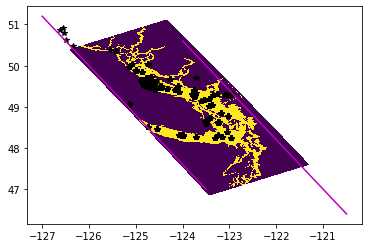

In [11]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as f:
    tmask=np.copy(f.variables['tmask'])
    lon=np.copy(f.variables['nav_lon'])
    lat=np.copy(f.variables['nav_lat'])
plt.pcolormesh(lon,lat,tmask[0,0,:,:])
plt.plot(df1.Lon,df1.Lat,'k*')
x0=-123.5
y0=47
x1=-126
y1=50
x=np.arange(-127,-123,.5)
y=y0+(y1-y0)/(x1-x0)*(x-x0) # take lat>47-3/2.5*(lon+123.5)
plt.plot(x,y,'m-')
x0=-121
y0=47
x1=-123.5
y1=50
x=np.arange(-124,-120,.5)
y=y0+(y1-y0)/(x1-x0)*(x-x0) # take lat<47-3/2.5*(lon+121)
plt.plot(x,y,'m-')

Text(0, 0.5, 'Si')

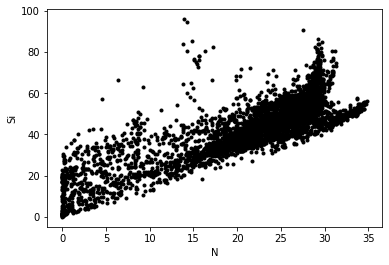

In [12]:
plt.plot(df1['N'],df1['Si'],'k.')
plt.xlabel('N')
plt.ylabel('Si')

In [13]:
from salishsea_tools import gsw_calls, viz_tools, geo_tools, tidetools
import datetime

In [14]:
depths = gsw_calls.generic_gsw_caller('gsw_z_from_p.m', 
                                      [df1.Pressure.values, df1.Lat.values])

In [15]:
depths = depths * -1

In [16]:
df1 = df1.assign(depth = depths)

In [17]:
df1.shape

(5213, 19)

In [18]:
df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon','Pressure']).shape

(5149, 19)

In [19]:
df1.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Ammonium', 'Ammonium_units', 'Chlorophyll_Extracted',
       'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal',
       'T', 'T_units', 'depth'],
      dtype='object')

In [20]:
df2 = df1.dropna(subset=['Year', 'Month', 'Hour', 'Lat', 'Lon', 'AbsSal', 'T'])

In [21]:
deptht = (nc.Dataset(
'/results/SalishSea/hindcast.201905/01jan15/SalishSea_1d_20150101_20150101_dia2_T.nc')
          .variables['deptht'][:])

In [22]:
deptht

masked_array(data=[  0.5000003,   1.5000031,   2.5000114,   3.5000305,
                     4.5000706,   5.5001507,   6.5003104,   7.500623 ,
                     8.501236 ,   9.502433 ,  10.5047655,  11.509312 ,
                    12.518167 ,  13.535412 ,  14.568982 ,  15.634288 ,
                    16.761173 ,  18.007135 ,  19.481785 ,  21.389978 ,
                    24.100256 ,  28.229916 ,  34.685757 ,  44.517723 ,
                    58.484333 ,  76.58559  ,  98.06296  , 121.866516 ,
                   147.08946  , 173.11449  , 199.57304  , 226.2603   ,
                   253.06664  , 279.93454  , 306.8342   , 333.75018  ,
                   360.67453  , 387.6032   , 414.5341   , 441.4661   ],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [23]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
HINDCAST_PATH= '/results/SalishSea/hindcast.201905/'

In [24]:
df2.shape

(5147, 19)

In [27]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_t = np.array([])
list_of_cs_s = np.array([])
list_of_model_t = np.array([])
list_of_model_s = np.array([])
list_of_depths = np.array([])
for n in df2.index:
    Yind, Xind = geo_tools.find_closest_model_point(df2.Lon[n], df2.Lat[n], 
                                                    X, Y, land_mask = bathy.mask)
    if ~np.isnan(Yind):
        depth = np.argmin(np.abs(deptht - df2.depth[n]))
        if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
            date = datetime.datetime(year = int(df2.Year[n]), month = int(df2.Month[n]),
                                    day = int(df2.Day[n]), hour = int(df2.Hour[n]),
                                     minute = int((df2.Hour[n] - int(df2.Hour[n]))*60))
            sub_dir = date.strftime('%d%b%y').lower()
            datestr = date.strftime('%Y%m%d')
            fname = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr, datestr)
            nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
            if date.minute < 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                after = before + datetime.timedelta(hours=1)
                sub_dir2 = after.strftime('%d%b%y').lower()
                datestr2 = after.strftime('%Y%m%d')
                fname2 = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr2, datestr2)
                nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
                delta = (date.minute + 30) / 60
                t_val = ((1-delta)*(nuts.variables['votemper'][before.hour, depth, Yind, Xind] ) + 
                           (delta)*(nuts2.variables['votemper'][after.hour, depth, Yind, Xind] ))
                s_val = ((1-delta)*(nuts.variables['vosaline'][before.hour, depth, Yind, Xind] ) + 
                           (delta)*(nuts2.variables['vosaline'][after.hour, depth, Yind, Xind] ))
            if date.minute >= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                after = before + datetime.timedelta(hours=1)
                sub_dir2 = after.strftime('%d%b%y').lower()
                datestr2 = after.strftime('%Y%m%d')
                fname2 = 'SalishSea_1h_{}_{}_grid_T.nc'.format(datestr2, datestr2)
                nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
                delta = (date.minute) / 60
                t_val = (delta*(nuts.variables['votemper'][before.hour, depth, Yind, Xind] ) + 
                           (1- delta)*(nuts2.variables['votemper'][after.hour, depth, Yind, Xind] ))
                s_val = (delta*(nuts.variables['vosaline'][before.hour, depth, Yind, Xind] ) + 
                           (1- delta)*(nuts2.variables['vosaline'][after.hour, depth, Yind, Xind] ))

            list_of_lons = np.append(list_of_lons, df2.Lon[n])
            list_of_lats = np.append(list_of_lats, df2.Lat[n])
            list_of_datetimes = np.append(list_of_datetimes, date)
            list_of_cs_t = np.append(list_of_cs_t, float(df2['T'][n]))
            list_of_cs_s = np.append(list_of_cs_s, float(df2['AbsSal'][n]))
            list_of_model_t = np.append(list_of_model_t, t_val)
            list_of_model_s = np.append(list_of_model_s, s_val)
            list_of_depths = np.append(list_of_depths, depth)

In [27]:
#import pickle

In [28]:
#pickle.dump(list_of_cs_s, open('dfo_sal.pkl', 'wb'))
#pickle.dump(list_of_cs_t, open('dfo_temp.pkl', 'wb'))
#pickle.dump(list_of_model_s, open('model_s_dfo.pkl', 'wb'))
#pickle.dump(list_of_model_t, open('model_t_dfo.pkl', 'wb'))

In [28]:
list_of_cs_t.shape

(5029,)

In [29]:
np.unique(list_of_depths)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       14., 15., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.])

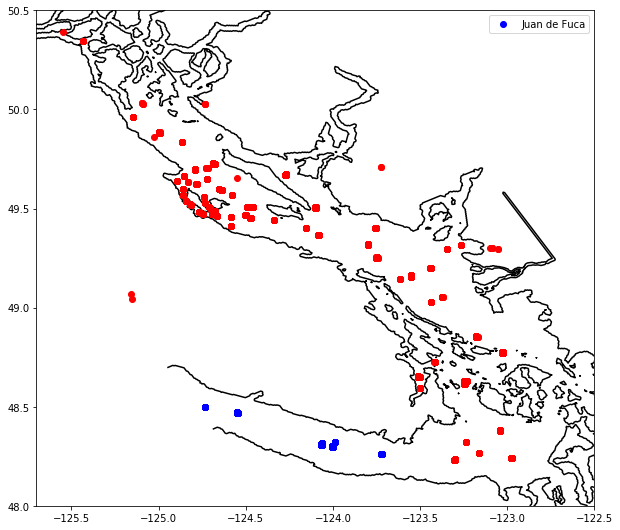

In [32]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
ax.plot(list_of_lons[(list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_lats[(list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        'bo', label = 'Juan de Fuca')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [34]:
list_of_lons[(list_of_lons < -125.0) & (list_of_lats < 49.5)]

array([-125.151     , -125.15616667])

surface bias =  0.16775668298327773
surface RMSE = 1.0291465645510223
surface Willmott = 0.9681542961419549
intermediate bias =  -0.011888561930415875
intermediate RMSE = 0.46579205699349735
intermediate Willmott = 0.9628830155608824
deep bias =  -0.029673768821004032
deep RMSE = 0.338188085440756
deep Willmott = 0.9630280590188297
bias =  0.03666102985233621
RMSE = 0.6592503925968322
Willmott = 0.9753227286741135


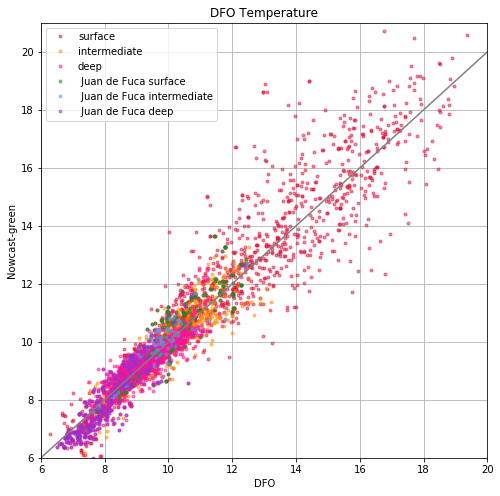

In [35]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_cs_t[list_of_depths < 15], list_of_model_t[list_of_depths < 15], 
        '.', color = 'Crimson', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15)], 
        '.', color = 'DarkOrange', alpha = 0.5, label = 'intermediate')
ax.plot(list_of_cs_t[list_of_depths >= 22], list_of_model_t[list_of_depths >= 22], 
        '.', color = 'DeepPink', alpha = 0.5, label = 'deep')

ax.plot(list_of_cs_t[(list_of_depths < 15) & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_model_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)], 
        '.', color = 'ForestGreen', alpha = 0.5, label = ' Juan de Fuca surface')
ax.plot(list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                      & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        '.', color = 'CornflowerBlue', alpha = 0.5, label = ' Juan de Fuca intermediate')
ax.plot(list_of_cs_t[(list_of_depths >= 22) & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_model_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)], 
        '.', color = 'DarkOrchid', alpha = 0.5, label = ' Juan de Fuca deep')

ax.plot(np.arange(0,35), color = 'grey')
ax.set_xlim(6,20)
ax.set_ylim(6,21)
ax.grid('on')
ax.set_title('DFO Temperature')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_t[list_of_depths < 15]) 
                               + np.mean(list_of_model_t[list_of_depths < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_t[list_of_depths < 15] 
                                              - list_of_cs_t[list_of_depths < 15])**2) /
                              len(list_of_cs_t[list_of_depths < 15]))))
xbar = np.mean(list_of_cs_t[list_of_depths < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_t[list_of_depths < 15] 
                                             - list_of_cs_t[list_of_depths < 15])**2)  / 
                             np.sum((np.abs(list_of_model_t[list_of_depths < 15] - xbar) 
                                     + np.abs(list_of_cs_t[list_of_depths < 15] - xbar))**2))))

print('intermediate bias =  ' + str(-np.mean(list_of_cs_t[(22 > list_of_depths) 
                                                           & (list_of_depths >= 15)]) 
                               + np.mean(list_of_model_t[(22 > list_of_depths) 
                                                          & (list_of_depths >= 15)])))
print('intermediate RMSE = ' + str(np.sqrt(np.sum((list_of_model_t[(22 > list_of_depths) 
                                                                    & (list_of_depths >= 15)] 
                                              - list_of_cs_t[(22 > list_of_depths) 
                                                              & (list_of_depths >= 15)])**2) /
                              len(list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15)]))))
xbar = np.mean(list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15)])
print('intermediate Willmott = ' + str(1-(np.sum((list_of_model_t[(22 > list_of_depths) 
                                                                   & (list_of_depths >= 15)] 
                                             - list_of_cs_t[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)])**2)  / 
                             np.sum((np.abs(list_of_model_t[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)] - xbar) 
                                     + np.abs(list_of_cs_t[(22 > list_of_depths) 
                                                            & (list_of_depths >= 15)] - xbar))**2))))

print('deep bias =  ' + str(-np.mean(list_of_cs_t[list_of_depths >= 22]) 
                               + np.mean(list_of_model_t[list_of_depths >= 22])))
print('deep RMSE = ' + str(np.sqrt(np.sum((list_of_model_t[list_of_depths >= 22] 
                                              - list_of_cs_t[list_of_depths >= 22])**2) /
                              len(list_of_cs_t[list_of_depths >= 22]))))
xbar = np.mean(list_of_cs_t[list_of_depths >= 22])
print('deep Willmott = ' + str(1-(np.sum((list_of_model_t[list_of_depths >= 22] 
                                             - list_of_cs_t[list_of_depths >= 22])**2)  / 
                             np.sum((np.abs(list_of_model_t[list_of_depths >= 22] - xbar) 
                                     + np.abs(list_of_cs_t[list_of_depths >= 22] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_t) + np.mean(list_of_model_t)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_t - list_of_cs_t)**2) /
                              len(list_of_cs_t))))
xbar = np.mean(list_of_cs_t)
print('Willmott = ' + str(1-(np.sum((list_of_model_t - list_of_cs_t)**2)  / 
                             np.sum((np.abs(list_of_model_t - xbar) 
                                     + np.abs(list_of_cs_t - xbar))**2))))

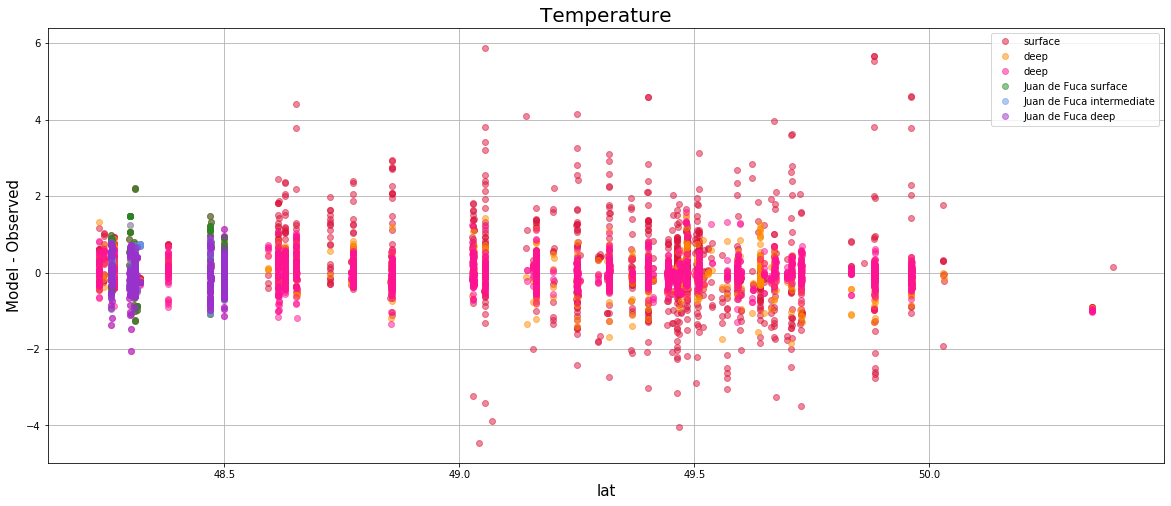

In [36]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths < 15], 
        list_of_model_t[list_of_depths < 15] 
        - list_of_cs_t[list_of_depths < 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lats[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15)] 
        - list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15)], 
        'o', color = 'DarkOrange', alpha =0.5, label = 'deep')
ax.plot(list_of_lats[list_of_depths >= 22], 
        list_of_model_t[list_of_depths >= 22] 
        - list_of_cs_t[list_of_depths >= 22], 'o', color = 'DeepPink',
        alpha =0.5, label = 'deep')

ax.plot(list_of_lats[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax.plot(list_of_lats[(22 > list_of_depths) & (list_of_depths >= 15) 
                     & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                        & (list_of_lons < -123.5) & (list_of_lats < 48.55)] 
       - list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                       & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       'o', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax.plot(list_of_lats[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')

ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Temperature', fontsize = 20);

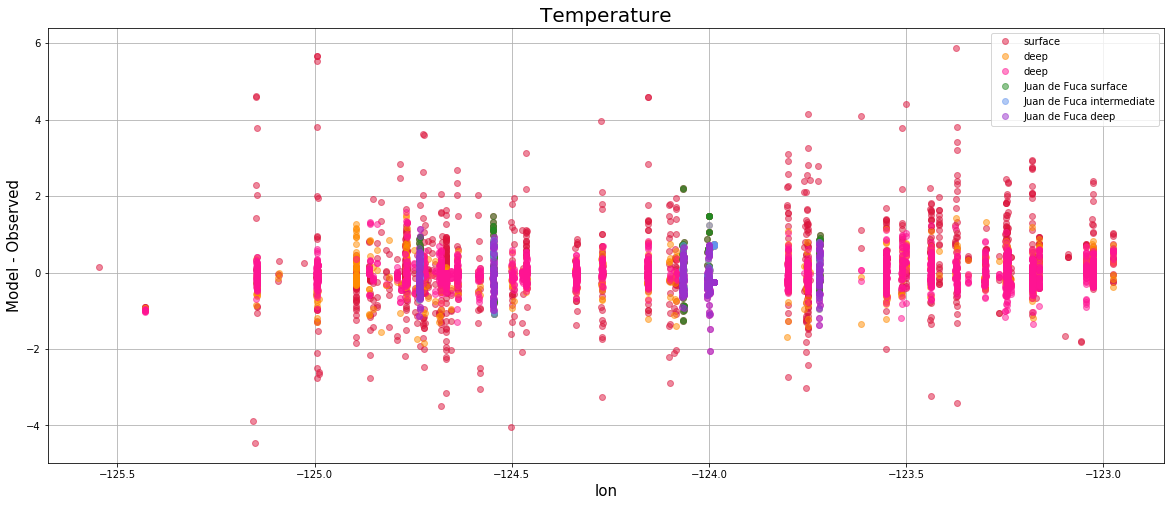

In [37]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths < 15], 
        list_of_model_t[list_of_depths < 15] 
        - list_of_cs_t[list_of_depths < 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lons[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15)] 
        - list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15)], 
        'o', color = 'DarkOrange', alpha =0.5, label = 'deep')
ax.plot(list_of_lons[list_of_depths >= 22], 
        list_of_model_t[list_of_depths >= 22] 
        - list_of_cs_t[list_of_depths >= 22], 'o', color = 'DeepPink',
        alpha =0.5, label = 'deep')

ax.plot(list_of_lons[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax.plot(list_of_lons[(22 > list_of_depths) & (list_of_depths >= 15) 
                     & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                        & (list_of_lons < -123.5) & (list_of_lats < 48.55)] 
       - list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                       & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       'o', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax.plot(list_of_lons[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')

ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Temperature', fontsize = 20);

/home/vdo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


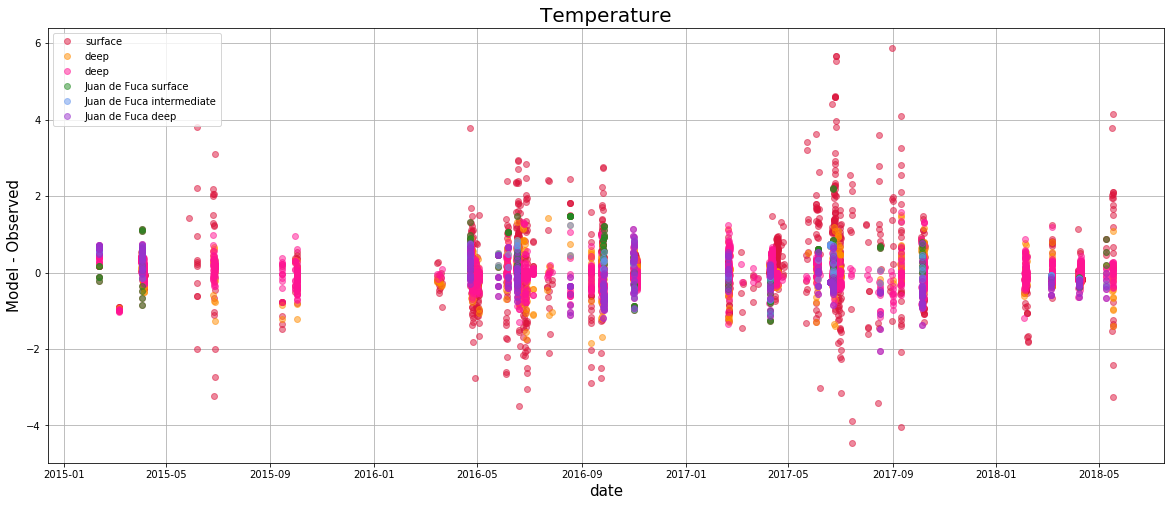

In [38]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths < 15], 
        list_of_model_t[list_of_depths < 15] 
        - list_of_cs_t[list_of_depths < 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'surface')
ax.plot(list_of_datetimes[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15)] 
        - list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15)], 
        'o', color = 'DarkOrange', alpha =0.5, label = 'deep')
ax.plot(list_of_datetimes[list_of_depths >= 22], 
        list_of_model_t[list_of_depths >= 22] 
        - list_of_cs_t[list_of_depths >= 22], 'o', color = 'DeepPink',
        alpha =0.5, label = 'deep')

ax.plot(list_of_datetimes[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_t[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax.plot(list_of_datetimes[(22 > list_of_depths) & (list_of_depths >= 15) 
                     & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       list_of_model_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                        & (list_of_lons < -123.5) & (list_of_lats < 48.55)] 
       - list_of_cs_t[(22 > list_of_depths) & (list_of_depths >= 15) 
                       & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       'o', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax.plot(list_of_datetimes[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_t[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')

ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Temperature', fontsize = 20);

surface bias =  -0.18504816562910875
surface RMSE = 1.6332325466123159
surface Willmott = 0.9203499738306792
intermediate bias =  0.060317341188870444
intermediate RMSE = 0.4229006731995478
intermediate Willmott = 0.9547227393262204
deep bias =  0.10506801976323743
deep RMSE = 0.2658087293329009
deep Willmott = 0.9890305446290928
bias =  0.004604375024925389
RMSE = 0.960716430694721
Willmott = 0.9613182118251861


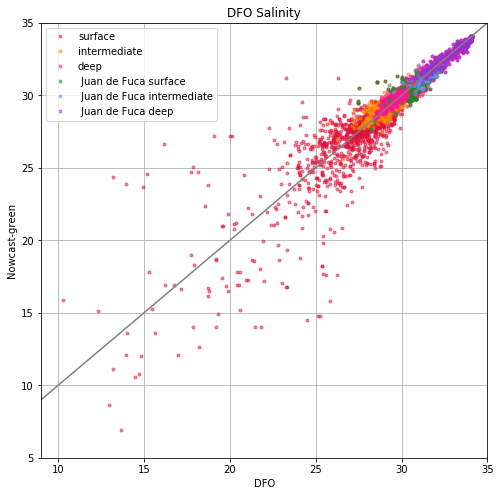

In [40]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(list_of_cs_s[list_of_depths < 15], list_of_model_s[list_of_depths < 15], 
        '.', color = 'Crimson', alpha = 0.5, label = 'surface')
ax.plot(list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15)], 
        '.', color = 'DarkOrange', alpha = 0.5, label = 'intermediate')
ax.plot(list_of_cs_s[list_of_depths >= 22], list_of_model_s[list_of_depths >= 22], 
        '.', color = 'DeepPink', alpha = 0.5, label = 'deep')

ax.plot(list_of_cs_s[(list_of_depths < 15) & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_model_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)], 
        '.', color = 'ForestGreen', alpha = 0.5, label = ' Juan de Fuca surface')
ax.plot(list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                      & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                         & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        '.', color = 'CornflowerBlue', alpha = 0.5, label = ' Juan de Fuca intermediate')
ax.plot(list_of_cs_s[(list_of_depths >= 22) & (list_of_lons < -123.5) & (list_of_lats < 48.55)], 
        list_of_model_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)], 
        '.', color = 'DarkOrchid', alpha = 0.5, label = ' Juan de Fuca deep')

ax.plot(np.arange(0,56), color = 'grey')
ax.grid('on')
ax.set_ylim(5, 35)
ax.set_xlim(9,35)
ax.set_title('DFO Salinity')
ax.set_xlabel('DFO')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_s[list_of_depths < 15]) 
                               + np.mean(list_of_model_s[list_of_depths < 15])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_s[list_of_depths < 15] 
                                              - list_of_cs_s[list_of_depths < 15])**2) /
                              len(list_of_cs_s[list_of_depths < 15]))))
xbar = np.mean(list_of_cs_s[list_of_depths < 15])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_s[list_of_depths < 15] 
                                             - list_of_cs_s[list_of_depths < 15])**2)  / 
                             np.sum((np.abs(list_of_model_s[list_of_depths < 15] - xbar) 
                                     + np.abs(list_of_cs_s[list_of_depths < 15] - xbar))**2))))

print('intermediate bias =  ' + str(-np.mean(list_of_cs_s[(22 > list_of_depths) 
                                                           & (list_of_depths >= 15)]) 
                               + np.mean(list_of_model_s[(22 > list_of_depths) 
                                                          & (list_of_depths >= 15)])))
print('intermediate RMSE = ' + str(np.sqrt(np.sum((list_of_model_s[(22 > list_of_depths) 
                                                                    & (list_of_depths >= 15)] 
                                              - list_of_cs_s[(22 > list_of_depths) 
                                                              & (list_of_depths >= 15)])**2) /
                              len(list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15)]))))
xbar = np.mean(list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15)])
print('intermediate Willmott = ' + str(1-(np.sum((list_of_model_s[(22 > list_of_depths) 
                                                                   & (list_of_depths >= 15)] 
                                             - list_of_cs_s[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)])**2)  / 
                             np.sum((np.abs(list_of_model_s[(22 > list_of_depths) 
                                                             & (list_of_depths >= 15)] - xbar) 
                                     + np.abs(list_of_cs_s[(22 > list_of_depths) 
                                                            & (list_of_depths >= 15)] - xbar))**2))))

print('deep bias =  ' + str(-np.mean(list_of_cs_s[list_of_depths >= 22]) 
                               + np.mean(list_of_model_s[list_of_depths >= 22])))
print('deep RMSE = ' + str(np.sqrt(np.sum((list_of_model_s[list_of_depths >= 22] 
                                              - list_of_cs_s[list_of_depths >= 22])**2) /
                              len(list_of_cs_s[list_of_depths >= 22]))))
xbar = np.mean(list_of_cs_s[list_of_depths >= 22])
print('deep Willmott = ' + str(1-(np.sum((list_of_model_s[list_of_depths >= 22] 
                                             - list_of_cs_s[list_of_depths >= 22])**2)  / 
                             np.sum((np.abs(list_of_model_s[list_of_depths >= 22] - xbar) 
                                     + np.abs(list_of_cs_s[list_of_depths >= 22] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_s) + np.mean(list_of_model_s)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_s - list_of_cs_s)**2) /
                              len(list_of_cs_s))))
xbar = np.mean(list_of_cs_s)
print('Willmott = ' + str(1-(np.sum((list_of_model_s - list_of_cs_s)**2)  / 
                             np.sum((np.abs(list_of_model_s - xbar) 
                                     + np.abs(list_of_cs_s - xbar))**2))))

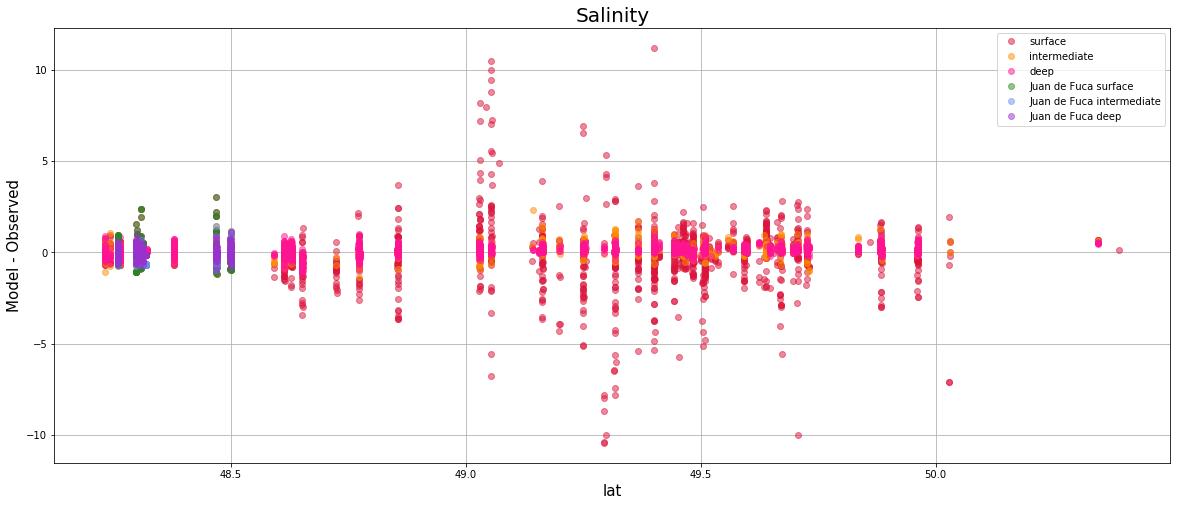

In [41]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths < 15], 
        list_of_model_s[list_of_depths < 15] 
        - list_of_cs_s[list_of_depths < 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lats[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15)] 
        - list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15)], 
        'o', color = 'DarkOrange', alpha =0.5, label = 'intermediate')
ax.plot(list_of_lats[list_of_depths >= 22], 
        list_of_model_s[list_of_depths >= 22] 
        - list_of_cs_s[list_of_depths >= 22], 'o', color = 'DeepPink',
        alpha =0.5, label = 'deep')

ax.plot(list_of_lats[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax.plot(list_of_lats[(22 > list_of_depths) & (list_of_depths >= 15) 
                     & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                        & (list_of_lons < -123.5) & (list_of_lats < 48.55)] 
       - list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                       & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       'o', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax.plot(list_of_lats[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')

ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Salinity', fontsize = 20);

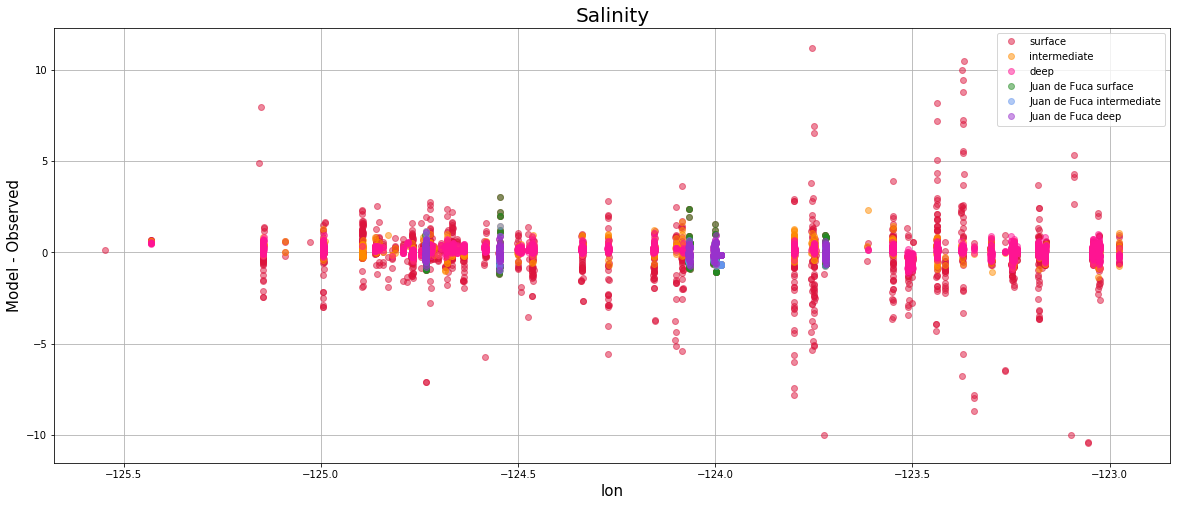

In [42]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths < 15], 
        list_of_model_s[list_of_depths < 15] 
        - list_of_cs_s[list_of_depths < 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'surface')
ax.plot(list_of_lons[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15)] 
        - list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15)], 
        'o', color = 'DarkOrange', alpha =0.5, label = 'intermediate')
ax.plot(list_of_lons[list_of_depths >= 22], 
        list_of_model_s[list_of_depths >= 22] 
        - list_of_cs_s[list_of_depths >= 22], 'o', color = 'DeepPink',
        alpha =0.5, label = 'deep')

ax.plot(list_of_lons[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax.plot(list_of_lons[(22 > list_of_depths) & (list_of_depths >= 15) 
                     & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                        & (list_of_lons < -123.5) & (list_of_lats < 48.55)] 
       - list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                       & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       'o', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax.plot(list_of_lons[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')

ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Salinity', fontsize = 20);

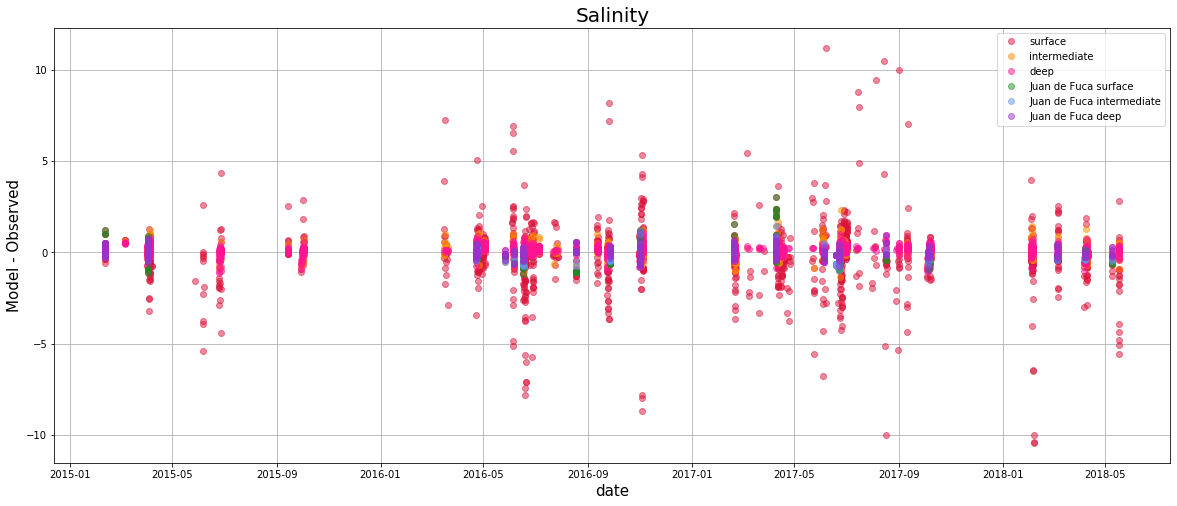

In [43]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths < 15], 
        list_of_model_s[list_of_depths < 15] 
        - list_of_cs_s[list_of_depths < 15], 'o', color = 'Crimson',
        alpha =0.5, label = 'surface')
ax.plot(list_of_datetimes[(22 > list_of_depths) & (list_of_depths >= 15)], 
        list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15)] 
        - list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15)], 
        'o', color = 'DarkOrange', alpha =0.5, label = 'intermediate')
ax.plot(list_of_datetimes[list_of_depths >= 22], 
        list_of_model_s[list_of_depths >= 22] 
        - list_of_cs_s[list_of_depths >= 22], 'o', color = 'DeepPink',
        alpha =0.5, label = 'deep')

ax.plot(list_of_datetimes[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_s[(list_of_depths < 15) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'ForestGreen', alpha = 0.5, label = 'Juan de Fuca surface')
ax.plot(list_of_datetimes[(22 > list_of_depths) & (list_of_depths >= 15) 
                     & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       list_of_model_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                        & (list_of_lons < -123.5) & (list_of_lats < 48.55)] 
       - list_of_cs_s[(22 > list_of_depths) & (list_of_depths >= 15) 
                       & (list_of_lons < -123.5) & (list_of_lats < 48.55)],
       'o', color = 'CornflowerBlue', alpha = 0.5, label = 'Juan de Fuca intermediate')
ax.plot(list_of_datetimes[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       list_of_model_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)] 
       - list_of_cs_s[(list_of_depths >= 22) & (list_of_lons < -123.5) 
                         & (list_of_lats < 48.55)],
       'o', color = 'DarkOrchid', alpha = 0.5, label = 'Juan de Fuca deep')

ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Salinity', fontsize = 20);